In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Set the input image size and number of classes
input_shape = (299, 299, 3)
num_classes = 9
batch_size = 32

# Create the InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [3]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up the data generators for training and testing
train_data_dir = 'C:\\Users\\bhaav\\Downloads\\Rice_data_pure_tarun\\training'
test_data_dir = 'C:\\Users\\bhaav\\Downloads\\Rice_data_pure_tarun\\testing'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 3561 images belonging to 9 classes.
Found 891 images belonging to 9 classes.


In [4]:
# Train the model with the original frozen layers
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
)

# Now, fine-tune the model by unfreezing some layers
base_model.trainable = True

# Fine-tune only the later layers
fine_tune_at = 200
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model after fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with fine-tuning
fine_tune_epochs = 50
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=fine_tune_epochs,
    validation_data=test_generator,
)

Epoch 1/20
111/111 [==============================] - 209s 2s/step - loss: 0.7444 - accuracy: 0.7458 - val_loss: 0.3609 - val_accuracy: 0.8754
Epoch 2/20
111/111 [==============================] - 188s 2s/step - loss: 0.3639 - accuracy: 0.8671 - val_loss: 0.3030 - val_accuracy: 0.8855
Epoch 3/20
111/111 [==============================] - 177s 2s/step - loss: 0.2808 - accuracy: 0.8954 - val_loss: 0.3015 - val_accuracy: 0.8855
Epoch 4/20
111/111 [==============================] - 165s 1s/step - loss: 0.2535 - accuracy: 0.9062 - val_loss: 0.2699 - val_accuracy: 0.8956
Epoch 5/20
111/111 [==============================] - 167s 2s/step - loss: 0.2415 - accuracy: 0.9096 - val_loss: 0.2915 - val_accuracy: 0.8923
Epoch 6/20
111/111 [==============================] - 174s 2s/step - loss: 0.2217 - accuracy: 0.9184 - val_loss: 0.2241 - val_accuracy: 0.9147
Epoch 7/20
111/111 [==============================] - 171s 2s/step - loss: 0.2237 - accuracy: 0.9139 - val_loss: 0.2032 - val_accuracy: 0.9192

In [6]:
# Evaluate the fine-tuned model on the test data
eval_result = model.evaluate(test_generator)
print('Fine-tuned Test loss:', eval_result[0])
print('Fine-tuned Test accuracy:', eval_result[1])

28/28 [==============================] - 15s 503ms/step - loss: 0.0852 - accuracy: 0.9809
Fine-tuned Test loss: 0.08520239591598511
Fine-tuned Test accuracy: 0.9809203147888184


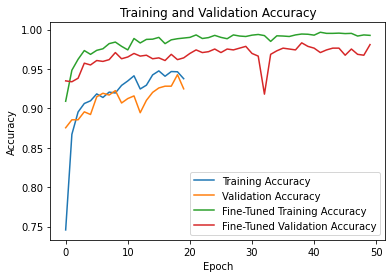

In [10]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine_tune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
# Make predictions on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate precision, recall, and f1 score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9810748574544185
Recall: 0.9809203142536476
F1 Score: 0.9809842022042746


In [13]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate specificity (True Negative Rate) for a specific class (assuming binary classification)
# For multi-class classification, calculate specificity for each class separately.
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Specificity:", specificity)


Specificity: 1.0


In [20]:
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score

# One-hot encode the true labels to match the format expected by roc_auc_score
from sklearn.preprocessing import label_binarize
y_true_one_hot = label_binarize(y_true, classes=range(num_classes))

# Calculate AUC-ROC for each class (one-vs-rest strategy)
auc_roc = roc_auc_score(y_true_one_hot, y_pred, average='macro')

print("AUC-ROC:", auc_roc)


AUC-ROC: 0.9990779246416288


In [22]:
# Calculate AUC-PR
from sklearn.metrics import average_precision_score
import numpy as np

# Convert y_true to binary format (one-hot encoded)
y_true_binary = np.zeros_like(y_pred)
y_true_binary[np.arange(len(y_true)), y_true] = 1

# Calculate AUC-PR for each class (one-vs-rest strategy)
auc_pr = average_precision_score(y_true_binary, y_pred, average='macro')

print("AUC-PR:", auc_pr)


AUC-PR: 0.9905806903022507


In [2]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)


NameError: name 'y_true' is not defined

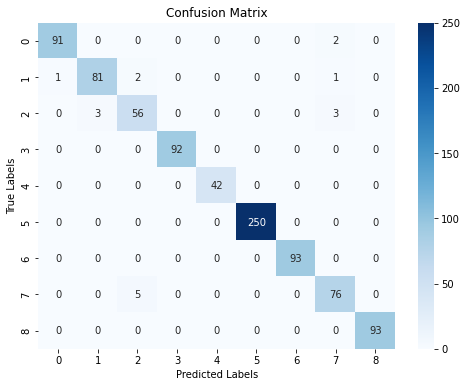

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Get class labels (assuming class indices are integers from 0 to num_classes-1)
class_labels = [str(i) for i in range(num_classes)]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
cohen_kappa = cohen_kappa_score(y_true, y_pred_classes)

print("Cohen's Kappa:", cohen_kappa)


Cohen's Kappa: 0.9776464667781367


In [1]:
from sklearn.metrics import matthews_corrcoef

# Calculate MCC
mcc = matthews_corrcoef(y_true, y_pred_classes)

print("Matthews Correlation Coefficient (MCC):", mcc)


NameError: name 'y_true' is not defined

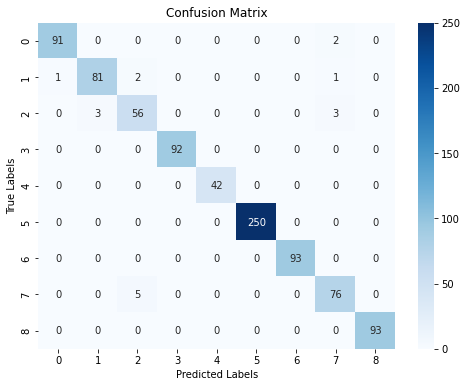

Model Accuracy: 0.9809203142536476
Precision: 0.9810748574544185
Recall: 0.9809203142536476
F1 Score: 0.9809842022042746
AUC-ROC per Class: [0.9994475435901582, 0.999080426215151, 0.9958558698782054, 1.0, 1.0, 1.0, 1.0, 0.9973174820911446, 1.0]
AUC-PR per Class: [0.9958365313088016, 0.9916217977470825, 0.9530766184275027, 1.0, 1.0, 1.0, 1.0, 0.9746912652368689, 1.0]
Average Inference Time per Sample: 0.023364557575757505


In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import timeit

# Assuming you have already calculated y_true and y_pred_classes

# Get the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Get class labels (assuming class indices are integers from 0 to num_classes-1)
class_labels = [str(i) for i in range(num_classes)]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate model accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Model Accuracy:", accuracy)

# Calculate precision, recall, and f1 score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate AUC-ROC
y_pred_prob = model.predict(test_generator)  # Assuming you have y_pred_prob from your model

# For multi-class, calculate AUC-ROC for each class (one-vs-rest strategy)
auc_roc = []
for i in range(num_classes):
    auc_roc_class = roc_auc_score(y_true_one_hot[:, i], y_pred_prob[:, i])
    auc_roc.append(auc_roc_class)

print("AUC-ROC per Class:", auc_roc)

# Calculate AUC-PR
# AUC-PR does not directly support multi-class, so we use one-vs-rest strategy
auc_pr = []
for i in range(num_classes):
    auc_pr_class = average_precision_score(y_true_binary[:, i], y_pred_prob[:, i])
    auc_pr.append(auc_pr_class)

print("AUC-PR per Class:", auc_pr)

# Measure Inference Speed
num_samples = len(test_generator.filenames)
inference_time = timeit.timeit(lambda: model.predict(test_generator), number=1)  # Single inference run

# Calculate average inference time per sample
avg_inference_time_per_sample = inference_time / num_samples
print("Average Inference Time per Sample:", avg_inference_time_per_sample)


In [30]:

# Assuming you have a specific image for which you want to generate the CAM
import cv2
from tf_explain.core.grad_cam import GradCAM

# Load and preprocess the image
img_path = 'path_to_your_image.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (input_shape[0], input_shape[1]))
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Create the GradCAM explainer
explainer = GradCAM()

# Generate the CAM visualization
cam_image = explainer.explain(validation_image, model, 'block_name_of_layer_to_visualize')

# Display the original image and the CAM visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.title('Class Activation Map (CAM)')
plt.show()


ModuleNotFoundError: No module named 'cv2'